## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
train_ext = pd.read_csv(f"/kaggle/input/isic2019-256x256/train.csv")
train_malig_1 = pd.read_csv(f"/kaggle/input/malignant-v2-256x256/train_malig_1.csv")
train_malig_3 = pd.read_csv(f"/kaggle/input/malignant-v2-256x256/train_malig_3.csv")
train['external'] = 0
train_ext['external'] = 1
train_malig_1['external'] = 0
train_malig_3['external'] = 0
train = pd.concat([train, train_ext, train_malig_1, train_malig_3])

test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 61853


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code,external
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0.0,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1.0,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2.0,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3.0,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4.0,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [4]:
display(train.describe())

,age_approx,target,tfrecord,width,height,patient_code,external
count,61275.000000,61853.000000,61853.000000,61853.000000,61853.000000,33710.000000,61853.000000
mean,51.555528,0.137455,11.685432,2579.533151,1798.705689,739.146544,0.409536
std,16.376824,0.344330,10.434983,2218.072246,1434.438340,530.738720,0.491752
min,0.000000,0.000000,-1.000000,576.000000,450.000000,0.000000,0.000000
25%,40.000000,0.000000,4.000000,824.000000,640.000000,275.000000,0.000000
50%,50.000000,0.000000,9.000000,1024.000000,1024.000000,663.000000,0.000000
75%,65.000000,0.000000,14.000000,5184.000000,3456.000000,1115.000000,1.000000
max,90.000000,1.000000,59.000000,6000.000000,6000.000000,2055.000000,1.000000


# Missing values

In [5]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
test['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
# anatom_site_general_challenge (NaN)
train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [6]:
### Label ecoding
enc = LabelEncoder()
train['sex_enc'] = enc.fit_transform(train['sex'].astype('str'))
test['sex_enc'] = enc.transform(test['sex'].astype('str'))

### One-hot ecoding
# train = pd.concat([train, pd.get_dummies(train['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# test = pd.concat([test, pd.get_dummies(test['sex'], prefix='sex_enc', drop_first=True)], axis=1)

### Mean ecoding
# Sex
train['sex_mean'] = train['sex'].map(train.groupby(['sex'])['target'].mean())
test['sex_mean'] = test['sex'].map(train.groupby(['sex'])['target'].mean())


# # External features
# train_img_ft = pd.read_csv('../input/landscape/TrainSuperTab.csv')
# test_img_ft = pd.read_csv('../input/landscape/TestSuperTab.csv')
# ext_fts = ['V1', 'V2', 'V3', 'V4','V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 
#            'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
#            'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
# for ft in ext_fts:
#     train[ft] = train_img_ft[ft]
#     test[ft] = test_img_ft[ft]

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code,external,sex_enc,sex_mean
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0.0,0,1,0.147700
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1.0,0,0,0.122992
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2.0,0,0,0.122992
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3.0,0,0,0.122992
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4.0,0,0,0.122992


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,sex_mean
0,ISIC_0052060,IP_3579794,male,70.0,NaN,1,0.147700
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.147700
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,0.122992
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,0.122992
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,0.122992


# Model

In [7]:
features = ['age_approx', 'sex_mean']

ohe_features  = [col for col in train.columns if 'enc' in col]

features += ohe_features

# External features
# features += ext_fts
print(features)

['age_approx', 'sex_mean', 'sex_enc']


In [8]:
# Hyperparameter grid
param_grid = {
    'max_depth': list(range(2, 12, 2)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.3, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'scale_pos_weight': list(np.linspace(1, (len(train[train['target'] == 0]) / len(train[train['target'] == 1])), 10)),
}


skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)

def get_idxs():
    for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
        x_train = train[(train['tfrecord'].isin(idxT) & (train['external'] == 0)) |      # 2020 data
                        (train['tfrecord'].isin(idxT * 2) & (train['external'] == 1)) |  # 2018 data
                        (train['tfrecord'].isin(idxT + 30) & (train['external'] == 0)) | # 2019 & 2018 data (malig)
                        (train['tfrecord'].isin(idxT + 15) & (train['external'] == 0))   # new data  (malig)
                       ]
        x_valid = train[~((train['tfrecord'].isin(idxT) & (train['external'] == 0)) |      # 2020 data
                          (train['tfrecord'].isin(idxT * 2) & (train['external'] == 1)) |  # 2018 data
                          (train['tfrecord'].isin(idxT + 30) & (train['external'] == 0)) | # 2019 & 2018 data (malig)
                          (train['tfrecord'].isin(idxT + 15) & (train['external'] == 0)))  # new data  (malig)
                       ]

        yield x_train.index, x_valid.index


# Model
model = XGBClassifier(n_estimators=300, random_state=SEED)

grid_search = RandomizedSearchCV(param_distributions=param_grid, estimator=model, scoring='roc_auc', 
                                 cv=iter(get_idxs()), n_jobs=-1, n_iter=100, verbose=1)
result = grid_search.fit(train[features], train['target'])

print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
params = result.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.5min finished


Best: 0.688285 using {'subsample': 0.5909090909090909, 'scale_pos_weight': 5.1028646854334925, 'reg_lambda': 0.22448979591836732, 'reg_alpha': 0.8775510204081632, 'max_depth': 4, 'learning_rate': 0.018261336821540877, 'colsample_bytree': 0.6888888888888889}
0.677438 (0.009971) with: {'subsample': 0.7171717171717171, 'scale_pos_weight': 5.688988211923991, 'reg_lambda': 0.5918367346938775, 'reg_alpha': 0.36734693877551017, 'max_depth': 4, 'learning_rate': 0.023422900579365236, 'colsample_bytree': 0.45555555555555555}
0.686241 (0.009020) with: {'subsample': 0.51010101010101, 'scale_pos_weight': 5.1028646854334925, 'reg_lambda': 0.6122448979591836, 'reg_alpha': 0.7755102040816326, 'max_depth': 8, 'learning_rate': 0.11650307053484622, 'colsample_bytree': 1.0}
0.679120 (0.009662) with: {'subsample': 0.9797979797979799, 'scale_pos_weight': 2.172247052980998, 'reg_lambda': 0.4081632653061224, 'reg_alpha': 0.36734693877551017, 'max_depth': 10, 'learning_rate': 0.12775485451762533, 'colsample_by

# Training

In [9]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0
model_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'train' if x['tfrecord'] in idxT else 'validation', axis=1)
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    model = XGBClassifier(**params, random_state=SEED)
    
    model.fit(x_train[features], y_train, eval_set=[(x_valid[features], y_valid)], eval_metric='auc', verbose=0)
    model_list.append(model)

    # Evaludation
    preds = model.predict_proba(train[features])[:, 1]
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = model.predict_proba(test[features])[:, 1]
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Model evaluation

In [10]:
def func(x):
    if x['fold_1'] == 'validation':
        return x['pred_fold_1']
    elif x['fold_2'] == 'validation':
        return x['pred_fold_2']
    elif x['fold_3'] == 'validation':
        return x['pred_fold_3']
    elif x['fold_4'] == 'validation':
        return x['pred_fold_4']
    elif x['fold_5'] == 'validation':
        return x['pred_fold_5']
    
train['pred'] = train.apply(lambda x: func(x), axis=1)

auc_oof = roc_auc_score(train['target'], train['pred'])
print(f'Overall OOF AUC = {auc_oof:.3f}')

df_oof = train[['image_name', 'target', 'pred']]
df_oof.to_csv('oof.csv', index=False)
display(df_oof.head())
display(df_oof.describe().T)

Overall OOF AUC = 0.664


,image_name,target,pred
0,ISIC_2637011,0,0.283471
1,ISIC_0015719,0,0.257451
2,ISIC_0052212,0,0.282585
3,ISIC_0068279,0,0.257451
4,ISIC_0074268,0,0.280337


,count,mean,std,min,25%,50%,75%,max
target,61853.0,0.137455,0.34433,0.000000,0.000000,0.000000,0.000000,1.000000
pred,61853.0,0.317036,0.09553,0.144455,0.240922,0.292434,0.358275,0.680218


# Feature importance

Fold: 1


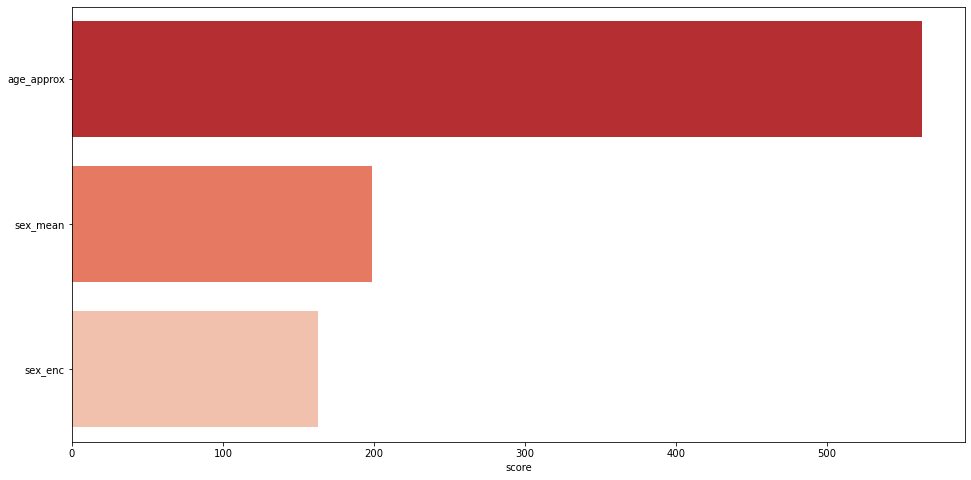

Fold: 2


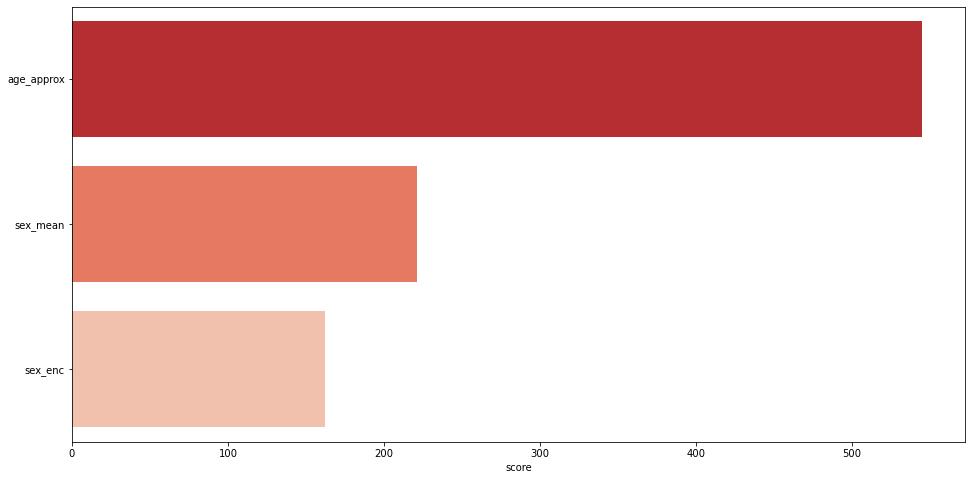

Fold: 3


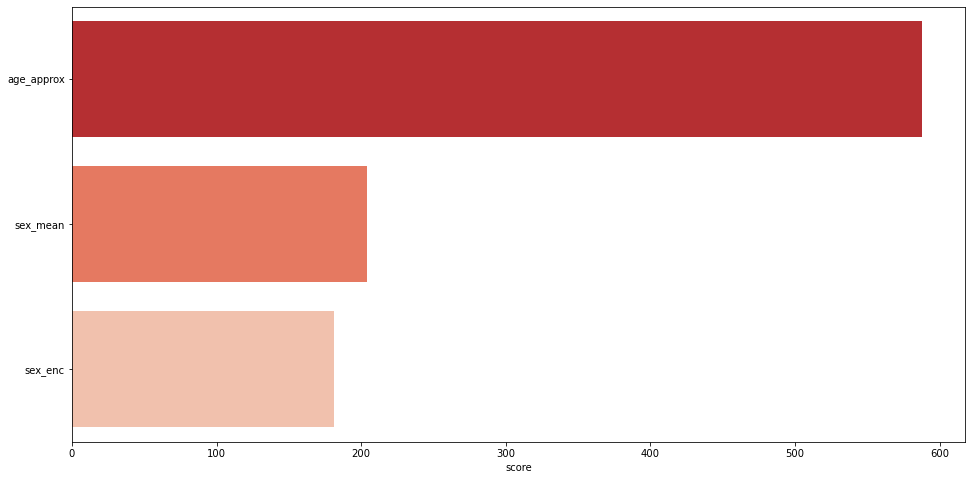

Fold: 4


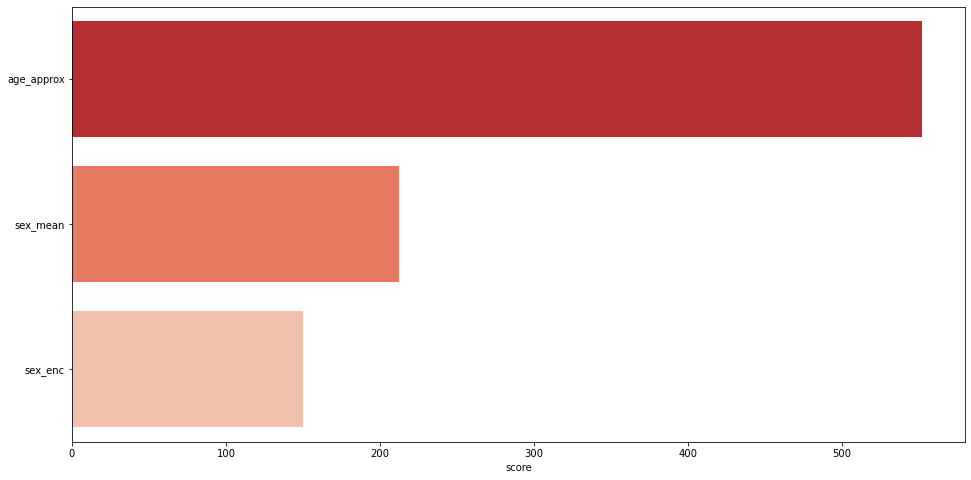

Fold: 5


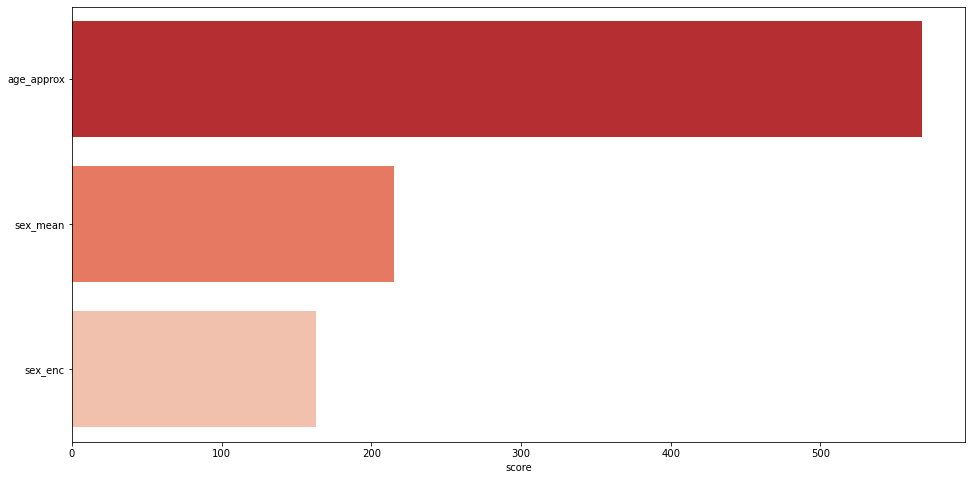

In [11]:
for n_fold, model in enumerate(model_list):
    print(f'Fold: {n_fold + 1}')
    feature_importance = model.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                              columns=['score']).sort_values(by='score',
                                                             ascending=False)
    plt.figure(figsize=(16, 8))
    sns.barplot(x=importance.score.iloc[:20],
                y=importance.index[:20],
                orient='h',
                palette='Reds_r')

    plt.show()

# Model evaluation

In [12]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.684684,0.648829,0.035855,0.683272,0.645162,0.683320,0.650106,0.681832,0.648821,0.688637,0.647104,0.686360,0.652953
Accuracy,0.900529,0.747803,0.152726,0.901488,0.746273,0.902554,0.744698,0.900656,0.747772,0.898253,0.751066,0.899692,0.749204
Precision,0.238726,0.394147,-0.155421,0.239024,0.395683,0.236602,0.391824,0.236857,0.390291,0.235450,0.401302,0.245699,0.391637
Recall,0.160221,0.172098,-0.011877,0.165852,0.169434,0.156074,0.173883,0.149799,0.177103,0.162409,0.171121,0.166971,0.168951
F1-score,0.191697,0.239556,-0.047860,0.195826,0.237268,0.188081,0.240872,0.183527,0.243646,0.192225,0.239932,0.198825,0.236064
Support,2706.400000,5795.600000,-3089.200000,2659.000000,5843.000000,2659.000000,5843.000000,2737.000000,5765.000000,2740.000000,5762.000000,2737.000000,5765.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.684684,0.648829,0.035855,0.683272,0.645162,0.683320,0.650106,0.681832,0.648821,0.688637,0.647104,0.686360,0.652953
male,0.679166,0.654705,0.024461,0.681080,0.651420,0.666782,0.668631,0.682015,0.640610,0.681135,0.656425,0.684818,0.656438
female,0.674388,0.629934,0.044454,0.663599,0.630950,0.686990,0.621235,0.667904,0.634295,0.685000,0.624530,0.668449,0.638658
head/neck,0.661072,0.585778,0.075294,0.675768,0.581224,0.663044,0.588656,0.650660,0.587139,0.652895,0.580870,0.662991,0.591001
upper extremity,0.685826,0.630767,0.055059,0.683153,0.619076,0.679256,0.633081,0.689253,0.625130,0.688052,0.632854,0.689417,0.643694
lower extremity,0.635180,0.622096,0.013085,0.633709,0.614351,0.631814,0.622351,0.634808,0.620844,0.646169,0.618354,0.629402,0.634580
torso,0.684235,0.672714,0.011521,0.672927,0.711670,0.680938,0.702373,0.681883,0.677523,0.701248,0.597885,0.684180,0.674117
0 <= age < 26,0.595797,0.547764,0.048033,0.574384,0.592407,0.674021,0.479699,0.591952,0.570851,0.559049,0.537311,0.579582,0.558553
26 <= age < 40,0.540936,0.470694,0.070242,0.494291,0.440593,0.548749,0.441227,0.568694,0.507091,0.540426,0.446781,0.552522,0.517781


# Adversarial Validation

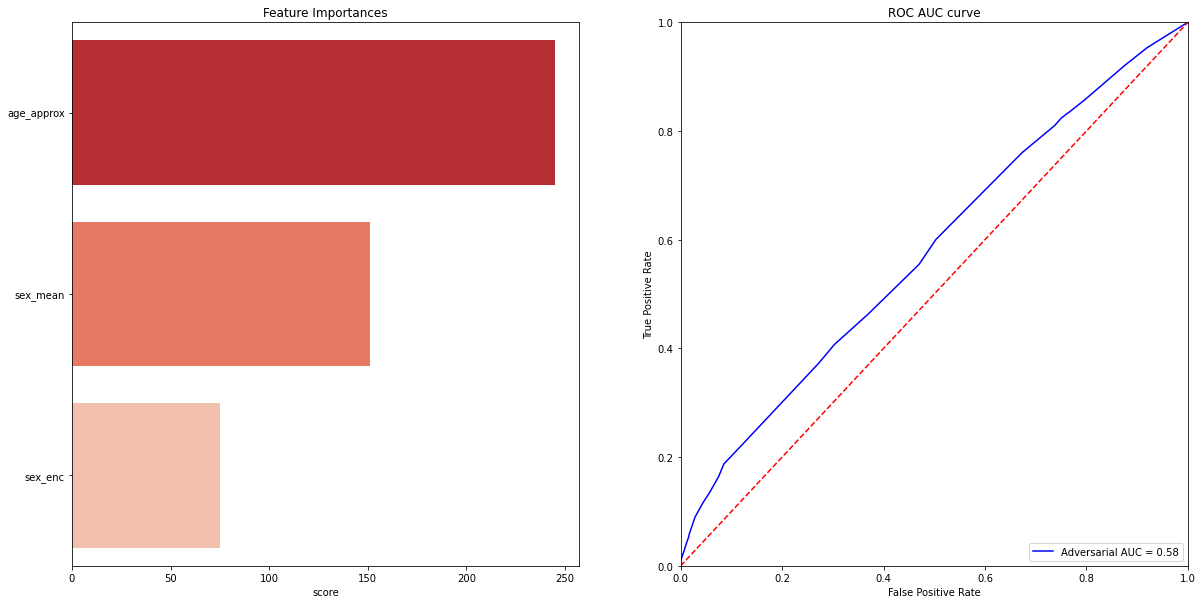

In [13]:
### Adversarial set
adv_train = train.copy()
adv_test = test.copy()
adv_train['dataset'] = 1
adv_test['dataset'] = 0

x_adv = pd.concat([adv_train, adv_test], axis=0)
y_adv = x_adv['dataset']

### Adversarial model
model_adv = XGBClassifier(**params, random_state=SEED)

model_adv.fit(x_adv[features], y_adv, eval_metric='auc', verbose=0)


### Preds
preds = model_adv.predict_proba(x_adv[features])[:, 1]


### Plot feature importance and ROC AUC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Feature importance
feature_importance = model_adv.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)

ax1.set_title('Feature Importances')
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r',
            ax=ax1)

# Plot ROC AUC curve
fpr_train, tpr_train, _ = roc_curve(y_adv, preds)
roc_auc_train = auc(fpr_train, tpr_train)

ax2.set_title('ROC AUC curve')
ax2.plot(fpr_train, tpr_train, color='blue', label='Adversarial AUC = %0.2f' % roc_auc_train)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

# Visualize predictions

In [14]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 8502
Train positive predictions: 4347
Train positive correct predictions: 1431
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.278157,0.283471,0.276211,0.279205,0.281242,0.270658
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.267798,0.257451,0.259602,0.277380,0.271016,0.273542
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.276962,0.258529,0.277826,0.285152,0.280718,0.282585
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.267798,0.257451,0.259602,0.277380,0.271016,0.273542
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.292803,0.280337,0.295640,0.294996,0.303933,0.289110
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.238456,0.229679,0.222022,0.249678,0.237522,0.253378
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.224147,0.216676,0.237863,0.226596,0.216934,0.222665
7,ISIC_0075663,female,35.0,torso,unknown,0,0.229271,0.228263,0.220531,0.239546,0.226526,0.231491
8,ISIC_0075914,male,30.0,torso,unknown,0,0.232452,0.245127,0.237582,0.225144,0.229382,0.225024
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.276962,0.258529,0.277826,0.285152,0.280718,0.282585


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.292803,0.280337,0.295640,0.294996,0.303933,0.289110
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.276962,0.258529,0.277826,0.285152,0.280718,0.282585
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.322299,0.321688,0.325143,0.323458,0.323494,0.317712
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.404311,0.406940,0.406726,0.406166,0.408009,0.393711
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.348888,0.336799,0.351552,0.358275,0.354325,0.343488
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.476691,0.483462,0.453379,0.486224,0.473902,0.486490
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.229271,0.228263,0.220531,0.239546,0.226526,0.231491
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.526334,0.526748,0.520435,0.535304,0.511241,0.537945
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.404311,0.406940,0.406726,0.406166,0.408009,0.393711
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.232452,0.245127,0.237582,0.225144,0.229382,0.225024


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
68,ISIC_0109568,male,80.0,lower extremity,unknown,0,0.526334,0.526748,0.520435,0.535304,0.511241,0.537945
75,ISIC_0114225,male,80.0,lower extremity,unknown,0,0.526334,0.526748,0.520435,0.535304,0.511241,0.537945
219,ISIC_0184482,female,85.0,torso,unknown,0,0.570307,0.566856,0.568288,0.570327,0.571593,0.574471
236,ISIC_0188926,male,80.0,torso,unknown,0,0.526334,0.526748,0.520435,0.535304,0.511241,0.537945
239,ISIC_0189333,female,85.0,head/neck,unknown,0,0.570307,0.566856,0.568288,0.570327,0.571593,0.574471
333,ISIC_0214335,male,80.0,head/neck,unknown,0,0.526334,0.526748,0.520435,0.535304,0.511241,0.537945
374,ISIC_0227038,male,80.0,torso,nevus,0,0.526334,0.526748,0.520435,0.535304,0.511241,0.537945
388,ISIC_0229832,female,85.0,torso,unknown,0,0.570307,0.566856,0.568288,0.570327,0.571593,0.574471
410,ISIC_0234248,female,80.0,torso,nevus,0,0.566846,0.553086,0.556204,0.572305,0.565835,0.586802
412,ISIC_0235728,male,85.0,head/neck,unknown,0,0.549665,0.559410,0.547257,0.554951,0.532829,0.553880


# Visualize test predictions

In [15]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 377|10605
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.424751,0.421294,0.416217,0.426019,0.424375,0.435851
1,ISIC_0052349,male,40.0,lower extremity,0.239066,0.241785,0.238207,0.235642,0.238774,0.240922
2,ISIC_0058510,female,55.0,torso,0.292803,0.280337,0.295640,0.294996,0.303933,0.289110
3,ISIC_0073313,female,50.0,torso,0.276962,0.258529,0.277826,0.285152,0.280718,0.282585
4,ISIC_0073502,female,45.0,lower extremity,0.267798,0.257451,0.259602,0.277380,0.271016,0.273542
5,ISIC_0074618,male,50.0,lower extremity,0.303851,0.301306,0.312929,0.293142,0.300588,0.311289
6,ISIC_0076801,male,45.0,upper extremity,0.278157,0.283471,0.276211,0.279205,0.281242,0.270658
7,ISIC_0077586,male,50.0,lower extremity,0.303851,0.301306,0.312929,0.293142,0.300588,0.311289
8,ISIC_0082004,female,45.0,torso,0.267798,0.257451,0.259602,0.277380,0.271016,0.273542
9,ISIC_0082785,male,65.0,lower extremity,0.404311,0.406940,0.406726,0.406166,0.408009,0.393711


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
31,ISIC_0131978,male,85.0,torso,0.549665,0.559410,0.547257,0.554951,0.532829,0.553880
36,ISIC_0148937,male,80.0,torso,0.526334,0.526748,0.520435,0.535304,0.511241,0.537945
56,ISIC_0169906,male,85.0,torso,0.549665,0.559410,0.547257,0.554951,0.532829,0.553880
69,ISIC_0182213,female,80.0,head/neck,0.566846,0.553086,0.556204,0.572305,0.565835,0.586802
88,ISIC_0197440,male,80.0,lower extremity,0.526334,0.526748,0.520435,0.535304,0.511241,0.537945
95,ISIC_0200120,female,85.0,torso,0.570307,0.566856,0.568288,0.570327,0.571593,0.574471
109,ISIC_0216447,male,80.0,head/neck,0.526334,0.526748,0.520435,0.535304,0.511241,0.537945
115,ISIC_0224309,female,85.0,upper extremity,0.570307,0.566856,0.568288,0.570327,0.571593,0.574471
140,ISIC_0244617,female,80.0,lower extremity,0.566846,0.553086,0.556204,0.572305,0.565835,0.586802
175,ISIC_0274789,male,80.0,torso,0.526334,0.526748,0.520435,0.535304,0.511241,0.537945


# Test set predictions

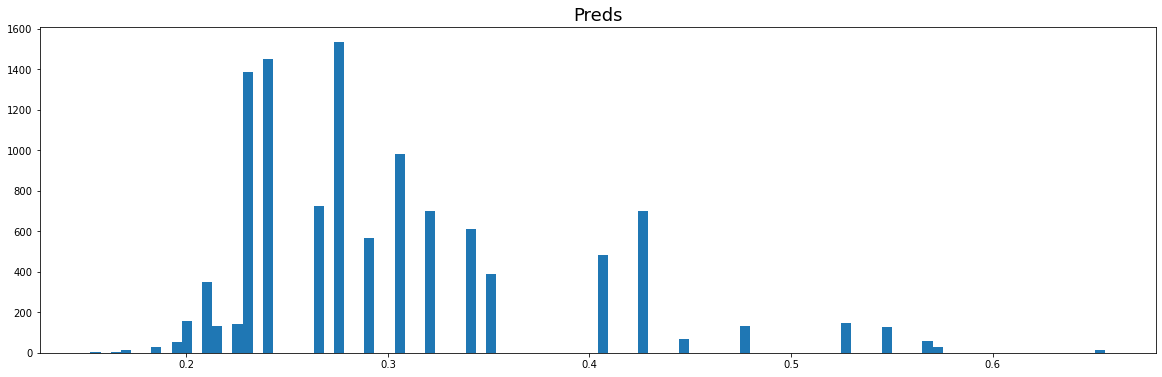

,image_name,target
0,ISIC_0052060,0.424751
1,ISIC_0052349,0.239066
2,ISIC_0058510,0.292803
3,ISIC_0073313,0.276962
4,ISIC_0073502,0.267798
5,ISIC_0074618,0.303851
6,ISIC_0076801,0.278157
7,ISIC_0077586,0.303851
8,ISIC_0082004,0.267798
9,ISIC_0082785,0.404311


,target
count,10982.000000
mean,0.300402
std,0.079126
min,0.152415
25%,0.238456
50%,0.278157
75%,0.343027
max,0.655750


In [16]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']

fig = plt.subplots(figsize=(20, 6))
plt.hist(submission['target'], bins=100)
plt.title('Preds', size=18)
plt.show()

display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)